# Forest cover prediction using deep learning
Data from the US Forest Service (USFS) Region 2 Resource Information System.
This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado.

It seems to come from Kaggle: https://www.kaggle.com/competitions/cover-type-prediction-of-forests/data

### Import modules
I like to keep my imports together

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


from matplotlib import pyplot as plt
from collections import Counter


## Import and explore dataset

In [4]:
dataset = pd.read_csv("cover_data.csv")

In [7]:
#Print info on the dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

Nice, all data is numeric.  

We want to predict the column "class"  
Let us see some more info

In [9]:
#print the class distribution
print(Counter(dataset["class"]))

Counter({2: 283301, 1: 211840, 3: 35754, 7: 20510, 6: 17367, 5: 9493, 4: 2747})


Forest Cover Type Classes (From Kaggle):  
1 -- Spruce/Fir  
2 -- Lodgepole Pine  
3 -- Ponderosa Pine  
4 -- Cottonwood/Willow  
5 -- Aspen  
6 -- Douglas-fir  
7 -- Krummholz

In [12]:
# Lets make a labels dict
labels = {1 : "Spruce/Fir",
          2 : "Lodgepole Pine",
          3 : "Ponderosa Pine",
          4 : "Cottonwood/Willow",
          5 : "Aspen",
          6 : "Douglas-fir",
          7 : "Krummholz"}

## Prepare data

First, select features and target data

In [13]:
x = dataset.iloc[:, :-1] # Features is everything but the last column in first approx
y = dataset.iloc[:, -1] # Target is the last column

Then, perform train test split

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 12)

Scale all input data using a ColumnTransformer

In [34]:
# Create the Transformer
numerical_data = x.select_dtypes(include = ["float64", "int64"])
numerical_columns = numerical_data.columns
ct = ColumnTransformer([("Only numerical columns", StandardScaler(), numerical_columns)], remainder = "passthrough")

# Scale data
x_train = ct.fit_transform(x_train)
x_test = ct.transform(x_test)

For Y we will use Sparse Crossentropy from Keras

In [35]:
# Sparse Crossentropy is 0 indexed, our y is 1 indexed
y_train = y_train - 1
y_test = y_test - 1

## Model Building

### Model 1: simple

Step 1: Define the model

In [25]:
# Building a simple sequential model
simple_model = Sequential() 
#add the input layer with a shape based on the Features
simple_model.add(layers.InputLayer(input_shape=(x_train.shape[1],)))
#add 2 hidden layers
simple_model.add(layers.Dense(28, activation='relu'))
simple_model.add(layers.Dense(14, activation='relu'))
#add an output layer
simple_model.add(layers.Dense(7, activation='softmax'))
# define optimizer and learning rate
learning rate = 0.001
opt = opt = tf.keras.optimizers.Adam(learning_rate = learning rate)
#compile the model, sparse categocical cross entropy, adam optimizer, simple accuracy metrics
simple_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(simple_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 28)                1540      
                                                                 
 dense_4 (Dense)             (None, 14)                406       
                                                                 
 dense_5 (Dense)             (None, 7)                 105       
                                                                 
Total params: 2,051
Trainable params: 2,051
Non-trainable params: 0
_________________________________________________________________
None


Step 2: initial fit

In [38]:
history = simple_model.fit(x_train, y_train, epochs=5, batch_size= 100, verbose=1, validation_split = 0.2)

Epoch 1/5
3487/3487 [==============================] - 32s 9ms/step - loss: 0.4795 - accuracy: 0.7956 - val_loss: 0.4800 - val_accuracy: 0.7947
Epoch 2/5
3487/3487 [==============================] - 34s 10ms/step - loss: 0.4742 - accuracy: 0.7979 - val_loss: 0.4740 - val_accuracy: 0.7991
Epoch 3/5
3487/3487 [==============================] - 37s 10ms/step - loss: 0.4683 - accuracy: 0.8011 - val_loss: 0.4733 - val_accuracy: 0.7974
Epoch 4/5
3487/3487 [==============================] - 36s 10ms/step - loss: 0.4635 - accuracy: 0.8031 - val_loss: 0.4659 - val_accuracy: 0.8013
Epoch 5/5
3487/3487 [==============================] - 33s 9ms/step - loss: 0.4588 - accuracy: 0.8058 - val_loss: 0.4640 - val_accuracy: 0.8003


Step 3: plot some results

Final training accuracy: 0.8057985305786133
Final validation accuracy: 0.8003488183021545


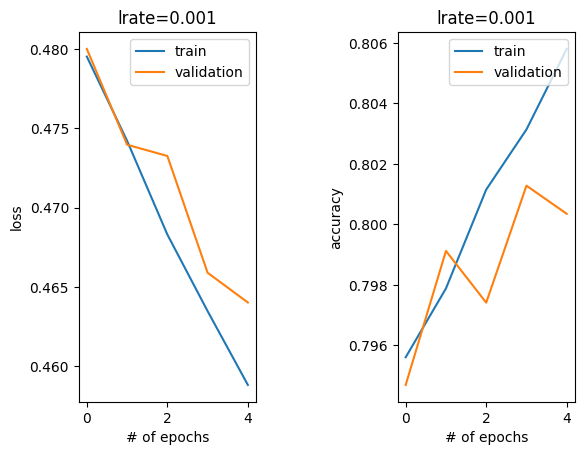

In [48]:
def plot(history):
    # plot learning curves
    fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 1, 'wspace': 0.8})
    (ax1, ax2) = axs
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')
    ax1.set_title('lrate=' + str(learning_rate))
    ax1.legend(loc="upper right")
    ax1.set_xlabel("# of epochs")
    ax1.set_ylabel("loss")

    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='validation')
    ax2.set_title('lrate=' + str(learning_rate))
    ax2.legend(loc="upper right")
    ax2.set_xlabel("# of epochs")
    ax2.set_ylabel("accuracy")
    print("Final training accuracy:", history.history['accuracy'][-1])
    print("Final validation accuracy:", history.history['val_accuracy'][-1])
    plt.show()

plot(history)

Step 4: Save model for later comparison

In [49]:
simple_model_file = "../models/simple_model"
simple_model.save(simple_model_file)

INFO:tensorflow:Assets written to: ../models/simple_model/assets


INFO:tensorflow:Assets written to: ../models/simple_model/assets
